# Prédiction, COVID en France, série temporelle

On s'intéresse aux séries temporelles de l'épidémie du COVID en France récupérées depuis data.gouv.fr : [Chiffres-clés concernant l'épidémie de COVID19 en France](https://www.data.gouv.fr/en/datasets/chiffres-cles-concernant-lepidemie-de-covid19-en-france/).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Données

In [3]:
from pandas import DataFrame, read_csv, to_datetime
df = read_csv("https://www.data.gouv.fr/en/datasets/r/0b66ca39-1623-4d9c-83ad-5434b7f9e2a4")
df['date'] = to_datetime(df['date'].apply(lambda s: s.replace("_", "-")))
df.tail()

c:\python387_x64\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,date,granularite,maille_code,maille_nom,cas_confirmes,cas_ehpad,cas_confirmes_ehpad,cas_possibles_ehpad,deces,deces_ehpad,reanimation,hospitalises,nouvelles_hospitalisations,nouvelles_reanimations,gueris,depistes,source_nom,source_url,source_archive,source_type
43080,2021-02-10,region,REG-75,Nouvelle-Aquitaine,NaN,NaN,NaN,NaN,2510.0,NaN,213.0,1524.0,78.0,20.0,10227.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr
43081,2021-02-10,region,REG-76,Occitanie,NaN,NaN,NaN,NaN,2882.0,NaN,276.0,1886.0,121.0,25.0,12801.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr
43082,2021-02-10,region,REG-84,Auvergne-Rhône-Alpes,NaN,NaN,NaN,NaN,8453.0,NaN,400.0,3699.0,213.0,42.0,34579.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr
43083,2021-02-10,region,REG-93,Provence-Alpes-Côte d'Azur,NaN,NaN,NaN,NaN,5010.0,NaN,438.0,3581.0,240.0,33.0,24080.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr
43084,2021-02-10,region,REG-94,Corse,NaN,NaN,NaN,NaN,133.0,NaN,7.0,58.0,4.0,3.0,587.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr


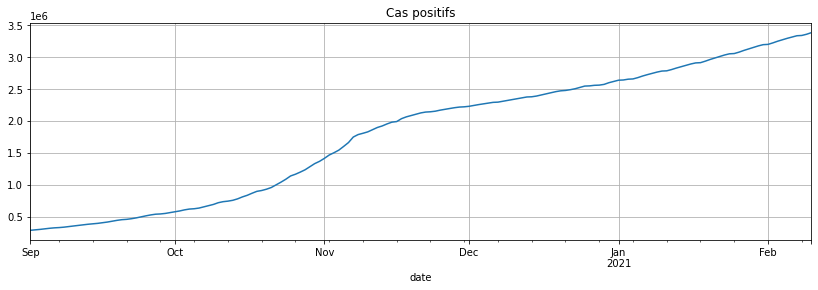

In [4]:
from datetime import datetime
gr = df[["date", "cas_confirmes"]].groupby("date").sum().sort_index()
gr.loc[datetime(2020, 11, 11), 'cas_confirmes'] = (
    gr.loc[datetime(2020, 11, 10), 'cas_confirmes'] + gr.loc[datetime(2020, 11, 12), 'cas_confirmes']) / 2
gr.loc[gr.index >= datetime(2020, 9, 1), 'cas_confirmes'].plot(figsize=(14, 4), grid=True, title="Cas positifs");

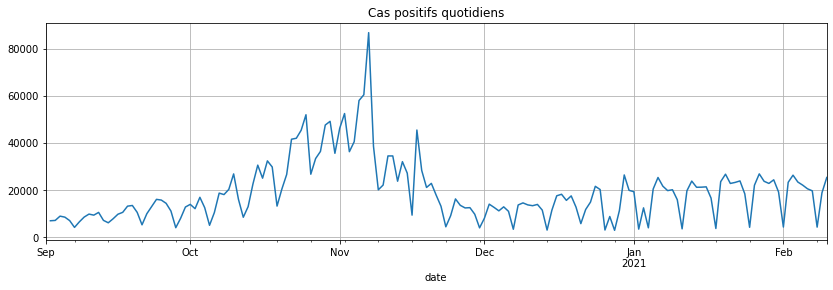

In [5]:
covsept = gr.loc[gr.index >= datetime(2020, 9, 1), 'cas_confirmes']
covsept.diff().plot(figsize=(14, 4), grid=True, title="Cas positifs quotidiens");

## Prédiction : AR

### Autocorrélogramme

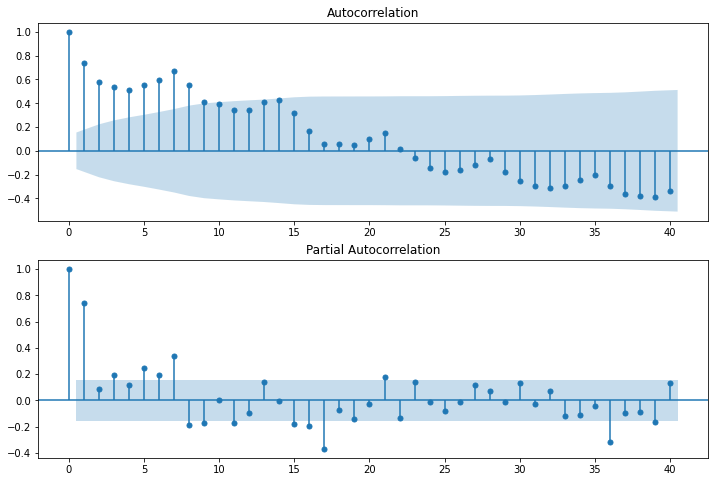

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data = covsept.diff()[1:]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data, lags=40, ax=ax2);

### ARIMA

In [7]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(data, order=(7, 1, 1))
res = mod.fit()
print(res.summary())

c:\python387_x64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\python387_x64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\python387_x64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:          cas_confirmes   No. Observations:                  162
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -1665.458
Date:                Thu, 11 Feb 2021   AIC                           3348.917
Time:                        00:17:40   BIC                           3376.649
Sample:                    09-02-2020   HQIC                          3360.177
                         - 02-10-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2273      0.162      1.407      0.159      -0.089       0.544
ar.L2         -0.1927      0.077     -2.508      0.012      -0.343      -0.042
ar.L3         -0.0039      0.103     -0.038      0.9

In [8]:
import numpy
pred = DataFrame({"cas+":data.copy()})
pred['pred'] = numpy.nan
pred['pred'] = res.forecasts.ravel()
pred.tail()

,cas+,pred
date,,
2021-02-06,20586.0,20346.037004
2021-02-07,19715.0,19741.530365
2021-02-08,4317.0,14212.567962
2021-02-09,18870.0,14869.262634
2021-02-10,25387.0,23740.270465


In [9]:
res.forecasts.ravel()[-5:]

array([20346.03700422, 19741.53036487, 14212.56796166, 14869.2626336 ,
       23740.27046459])

In [10]:
res.forecast(7)

2021-02-11    21924.732356
2021-02-12    21223.595082
2021-02-13    18260.072157
2021-02-14    18045.532220
2021-02-15    13187.175698
2021-02-16    17328.572392
2021-02-17    22102.419937
Freq: D, Name: predicted_mean, dtype: float64

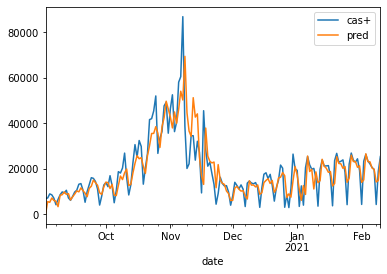

In [11]:
pred.plot();

## Approche machine learning

In [12]:
def lagged_dataframe(data, lag=7):
    res = data.copy()
    data = res.iloc[:, 0]
    for i in range(1, lag):
        res['l%i' % i] = data.shift(i)
    return res[lag:].copy()

lagged_dataframe(DataFrame({'cas+': data}), 8)

,cas+,l1,l2,l3,l4,l5,l6,l7
date,,,,,,,,
2020-09-10,9843.0,8577.0,6544.0,4203.0,7071.0,8550.0,8975.0,7157.0
2020-09-11,9406.0,9843.0,8577.0,6544.0,4203.0,7071.0,8550.0,8975.0
2020-09-12,10561.0,9406.0,9843.0,8577.0,6544.0,4203.0,7071.0,8550.0
2020-09-13,7183.0,10561.0,9406.0,9843.0,8577.0,6544.0,4203.0,7071.0
2020-09-14,6158.0,7183.0,10561.0,9406.0,9843.0,8577.0,6544.0,4203.0
...,...,...,...,...,...,...,...,...
2021-02-06,20586.0,22139.0,23448.0,26362.0,23337.0,4347.0,19235.0,24392.0
2021-02-07,19715.0,20586.0,22139.0,23448.0,26362.0,23337.0,4347.0,19235.0
2021-02-08,4317.0,19715.0,20586.0,22139.0,23448.0,26362.0,23337.0,4347.0


In [13]:
feat = lagged_dataframe(DataFrame({'cas+': data}), 8)
X, y = feat.drop('cas+', axis=1), feat['cas+']
X.shape, y.shape

((154, 7), (154,))

### Régression linéaire

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lr = make_pipeline(StandardScaler(), LinearRegression())
lr.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [15]:
from sklearn.metrics import r2_score
r2_score(y, lr.predict(X))

0.639550667481653

In [16]:
r2_score(y, X.values[:, 0])

0.4573617856901514

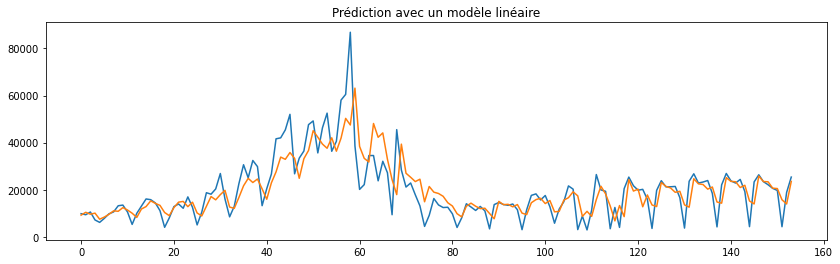

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(y.values)
ax.plot(lr.predict(X))
ax.set_title("Prédiction avec un modèle linéaire");

### Autres modèles

Overfitting ?

In [18]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X, y):
    X_train, X_test, y_train, y_test = (
        X.iloc[train_index, :], X.iloc[test_index, :],
        y.iloc[train_index], y.iloc[test_index])
    print("TRAIN:", X_train.shape, "TEST:", X_test.shape)

TRAIN: (29, 7) TEST: (25, 7)
TRAIN: (54, 7) TEST: (25, 7)
TRAIN: (79, 7) TEST: (25, 7)
TRAIN: (104, 7) TEST: (25, 7)
TRAIN: (129, 7) TEST: (25, 7)
